In [1]:
from __future__ import division, print_function, absolute_import

#Introduction to Visualization:
Density Estimation,  Dimensionality Reduction, and Data Exploration
========

#####Version 0.1

There are many flavors of data analysis that fall under the "visualization" umbrella in astronomy. Today, by way of example, we will focus on 3 basic problems that illustrate the various issues at hand. 

***
By AA Miller (c) 22 July 2016


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

##Problem 1) Density Estimation

Starting with 2MASS and SDSS and extending through LSST, we are firmly in an era where data and large statistical samples are cheap. With this explosion in data volume comes a problem: in most cases we do not know the underlying probability density function (PDF) of the random variables measured via our observations. Hence - density estimation: an attempt to recover the unknown PDF from observations. In some cases theory can guide us to a parametric form for the PDF, but more often than not, this is not the case. 

There is a common, simple and very familiar tool for density estimation: histograms. But there is also a problem: histograms lie! We will "prove" this to be the case in a series of examples. For this exercise, we will load the famous Linnerud data set, which tested 20 middle aged men by measuring the number of chinups, situps, and jumps they could do in order to compare these numbers to their weight, pulse, and waist size. To load the data (just chinups for now) we will run the following:

    from sklearn.datasets import load_linnerud
    linnerud = load_linnerud()
    chinups = linnerud.data[:,0]

In [3]:
#execute this cell
from sklearn.datasets import load_linnerud

linnerud = load_linnerud()
chinups = linnerud.data[:,0]

**Problem 1a** Plot the histogram for the number of chinups using the default settings in pyplot.

*Hint - `plt.hist()` takes a univariate data array as an argument and plots a histogram. I suggest setting `histtype = "step"` for clarity during this exercise. 

(array([ 3.,  2.,  1.,  2.,  1.,  0.,  4.,  2.,  3.,  2.]),
 array([  1. ,   2.6,   4.2,   5.8,   7.4,   9. ,  10.6,  12.2,  13.8,
         15.4,  17. ]),
 <a list of 1 Patch objects>)

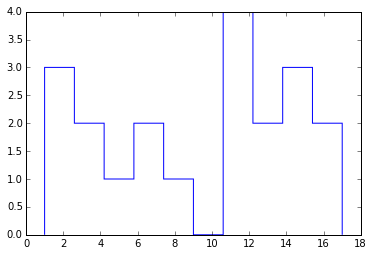

In [4]:
plt.hist(chinups,histtype="step")# complete

Already with this simple plot we see a problem - the choice of bin centers and number of bins suggest that there is a 0% probability that middle aged men can do 10 chinups. Intuitively this seems absolutely incorrect, so lets examine how the histogram changes if we change the number of bins or the bin centers.

**Problem 1b** Re-plot the histogram with two different iterations: (i) 5 bins (`bins = 5`), and (ii) with bars centered on the left bin edges (`align = "left"`).

*Hint - if overplotting the results, you may find it helpful to use the `histtype = "step"` option.*

(array([ 3.,  2.,  1.,  2.,  1.,  0.,  4.,  2.,  3.,  2.]),
 array([  1. ,   2.6,   4.2,   5.8,   7.4,   9. ,  10.6,  12.2,  13.8,
         15.4,  17. ]),
 <a list of 1 Patch objects>)

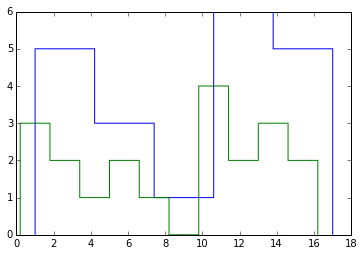

In [5]:
plt.hist(chinups,histtype="step",bins=5) # complete
plt.hist(chinups,histtype="step",align="left") # complete

These small changes significantly change the output PDF. With fewer bins we get something closer to a continuous distribution, while shifting the bin centers reduces the probability to zero at 9 chinups. 

What if we instead allow the bin width to vary, and instead require the same number of points in each bin? You can determine the bin edges for bins with 5 sources using the following command:
    
    bins = np.append(np.sort(chinups)[::5], np.max(chinups))

**Problem 1c** Plot a histogram with variable width bins, each with the same number of points.

*Hint - setting `normed = True` will normalize the bin heights so that the PDF integrates to 1.*

(array([ 0.0625    ,  0.03571429,  0.125     ,  0.08333333]),
 array([  1.,   5.,  12.,  14.,  17.]),
 <a list of 1 Patch objects>)

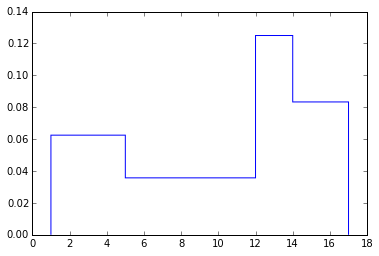

In [10]:
bins = np.append(np.sort(chinups)[::5],np.max(chinups)) # complete
plt.hist(chinups,histtype="step",bins=bins,normed=True)# complete

*Ending the lie* Earlier I stated that histograms lie. One simple way to combat this lie: show all the data. Displaying the original data points allows viewers to (somewhat) intuit the effects of the bin selection. (*Note* - this can be cumbersome for very large data sets, which these days is essentially all data sets).  The standard for showing individual observations relative to a histogram is a "rug plot," which shows a vertical tick (or other symbol) at the location of each source used to estimate the PDF.

**Problem 1d** Execute the cell below to see an example of a rug plot. 

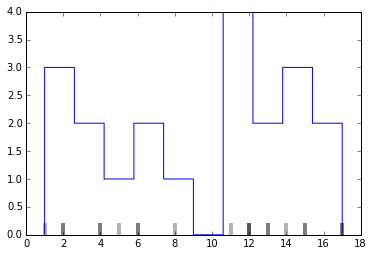

In [5]:
# execute this cell
plt.hist(chinups, histtype = 'step')

# this is the code for the carpet plot
plt.plot(chinups, np.zeros_like(chinups), '|', color='k', ms = 25, mew = 4, alpha=0.3)

Or course, even rug plots are not a perfect solution. Many of the chinup measurements are repeated, and those instances cannot be easily isolated above. One (slightly) better solution is to vary the transparency of the rug "whiskers" using `alpha = 0.3` in the whiskers plot call. But this too is far from perfect. To recap, histograms are not ideal for density estimation for the following reasons: 

* They introduce discontinuities that are not present in the data
* They are strongly sensitive to user choices ($N_\mathrm{bins}$, bin centering, bin grouping), without any mathematical guidance to what these choices should be
* They are difficult to visualize in higher dimensions

Histograms are useful for generating a quick representation of univariate data, but for the reasons listed above they should never be used for analysis. Most especially, functions should not be fit to histograms given how greatly the number of bins and bin centering affects the output histogram.

Okay - so if we are going to rail on histograms this much, there must be a better option. There is: [Kernel Density Estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE), a nonparametric form of density estimation whereby a normalized kernel function is convolved with the discrete data to obtain a continuous estimate of the underlying PDF. As a rule, the kernel must integrate to 1 over the interval $-\infty$ to $\infty$ and be symmetric. There are many possible kernels (gaussian is highly popular, though Epanechnikov, an inverted parabola, produces the minimal mean square error). 

KDE is not completely free of the problems we illustrated for histograms above (in particular, both a kernel and the width of the kernel need to be selected), but it does manage to correct a number of the ills. We will now demonstrate this via a few examples using the `scikit-learn` implementation of KDE: [`KernelDensity`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html#sklearn.neighbors.KernelDensity), which is part of the [`sklearn.neighbors`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.neighbors) module. 

*Note* There are many implementations of KDE in Python, and our very own Jake VanderPlas has put together [an excellent description of the strengths and weaknesses of each](https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/). We will use the `scitkit-learn` version as it is in many cases the fastest implementation.

To demonstrate the basic idea behind KDE, we will being by representing each point in the dataset as a block (i.e. we will adopt the tophat kernel). Borrowing some code from Jake, we can estimate the KDE using the following code:

    from sklearn.neighbors import KernelDensity
    def kde_sklearn(data, grid, bandwidth = 1.0, **kwargs):
        kde_skl = KernelDensity(bandwidth = bandwidth, **kwargs)
        kde_skl.fit(data[:, np.newaxis])
        log_pdf = kde_skl.score_samples(grid[:, np.newaxis]) # sklearn returns log(density)
        
        return np.exp(log_pdf)
        
The two main options to set are the bandwidth and the kernel. 

In [6]:
# execute this cell
from sklearn.neighbors import KernelDensity
def kde_sklearn(data, grid, bandwidth = 1.0, **kwargs):
    kde_skl = KernelDensity(bandwidth = bandwidth, **kwargs)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(grid[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

**Problem 1e** Plot the KDE of the PDF for the number of chinups middle aged men can do using a bandwidth of 0.1 and a tophat kernel.

*Hint - as a general rule, the grid separation should be smaller than the bandwidth when plotting the PDF. 

Also - in this case you want to set `kernel = "tophop"` as a `kwarg` for `kde_sklearn`.*

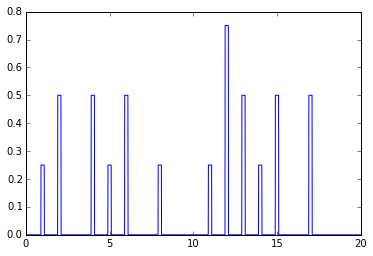

In [23]:
grid = np.arange(0 + 1e-4,20,0.01) # complete
PDFtophat = kde_sklearn(chinups,grid,0.1,kernel="tophat") # complete

plt.plot(grid, PDFtophat) #complete

In this representation, each "block" has a height of 0.25. The bandwidth is too short to provide any overlap between the blocks. This choice of kernel and bandwidth produces an estimate that is essentially a histogram with a large number of bins. It gives no sense of continuity for the distribution. Now, we examine the difference (relative to histograms) upon changing the the width of the blocks (i.e. the KDE bandwidth). 

**Problem 1f** Plot the KDE of the PDF for the number of chinups middle aged men can do using bandwidths of 1 and 5 for the tophat kernel. How do the results differ from the histogram plots above? 

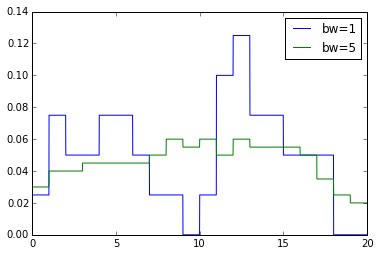

In [24]:
PDFtophat1 = kde_sklearn(chinups,grid,1,kernel='tophat') # complete
plt.plot(grid,PDFtophat1,color='b',label='bw=1') # complete

PDFtophat5 = kde_sklearn(chinups,grid,5,kernel='tophat') # complete
plt.plot(grid,PDFtophat5,color='g',label='bw=5') # complete
plt.legend()

It turns out blocks are not an ideal representation for continuous data (see discussion on histograms above). Now we will explore the resulting PDF from other kernels. 


**Problem 1g** Plot the KDE of the PDF for the number of chinups middle aged men can do using a gaussian and Epanechnikov kernel. How do the results differ from the histogram plots above? 

*Hint - you will need to select the bandwidth. The examples above should provide insight into the useful range for bandwidth selection. You may need to adjust the values to get an answer you "like."*

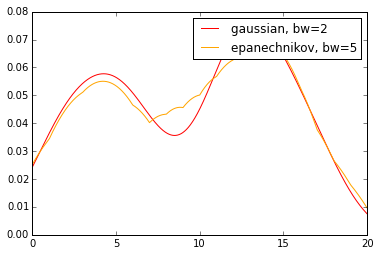

In [30]:
PDFgaussian = kde_sklearn(chinups,grid,2,kernel='gaussian') # complete
plt.plot(grid,PDFgaussian,color='r',label='gaussian, bw=2')
PDFepanechnikov = kde_sklearn(chinups,grid,5,kernel='epanechnikov') # complete
plt.plot(grid,PDFepanechnikov,color='orange',label='epanechnikov, bw=5')
plt.legend()

So, what is the *optimal* choice of bandwidth and kernel? Unfortunately, there is no hard and fast rule, as every problem will likely have a different optimization. Typically, the choice of bandwidth is far more important than the choice of kernel. In the case where the PDF is likely to be gaussian (or close to gaussian), then [Silverman's rule of thumb](https://en.wikipedia.org/wiki/Kernel_density_estimation#A_rule-of-thumb_bandwidth_estimator) can be used: 

$$h = 1.059 \hat{\sigma} n^{-1/5}$$

where $h$ is the bandwidth, $\hat{\sigma}$ is the standard deviation of the samples, and $n$ is the total number of samples. Note - in situations with bimodal or more complicated distributions, this rule of thumb can lead to woefully inaccurate PDF estimates. The most general way to estimate the choice of bandwidth is via cross validation (we will cover cross-validation in further detail tomorrow). 

*What about multidimensional PDFs?* It is possible using many of the Python implementations of KDE to estimate multidimensional PDFs, though it is very very important to beware the curse of dimensionality in these circumstances.

**Problem 1h** *Essentially, the Challenge Problem* The code below will generate random samples from two different gaussian distributions, one with 200 data points and the other with 1000 data points. Use KDE to estimate the PDF for each distribution, then select a subset of 100 sources from the 1000 data point set that approximates the PDF of the 200 data point set. Confirm your results with plots. 

*Hint - np.random.choice() allows weighted random selections from an array using the `p = probability` option, where `probability`. Note that the probabilites must sum to 1.*

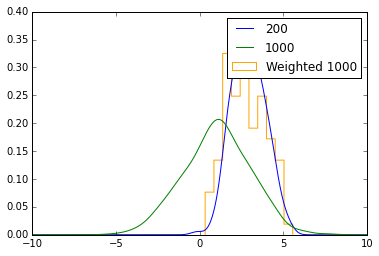

In [33]:
# complete
data200 = np.random.normal(loc = 3, scale = 1, size = 200)
data1000 = np.random.normal(loc = 1, scale = 2, size = 1000)


# bandwidths based on Silverman's rule of thumb
h200 = 1.059*np.std(data200)*np.power(200,-1/5)
h1000 = 1.059*np.std(data1000)*np.power(1000,-1/5)

grid1 = np.arange(-10,10,.01)

# the KDEs
PDFgaussian200 = kde_sklearn(data200,grid1,h200,kernel='gaussian')
PDFgaussian1000 = kde_sklearn(data1000,grid1,h1000,kernel='gaussian')


"""
For my own reference:
kde_sklearn creates a fit based on the data, then scores the 'grid' as it fits. By making the 'grid' the 1000-sample data,
we can give preference to the points that are closer to the center of the 200-sample data.

The following is my initial attempt, however, it fails to take into account the fact that there are way more 
of the 1000 samples on the lower side of the 200-sample midpoint. This oversight moves the center of the
histogram to the left, to the middle of the 200 and 1000 sample midpoints.

    w200 = kde_sklearn(data200,data1000,h200,kernel='gaussian')
    weights = w200/sum(w200)
    weighted1000 = np.random.choice(data1000,size=100,replace=False,p=weights)

The following way further weights the 200-sample midpoint and releives weight from the section between the
two midpoints while granting extra weight to the far side of the midpoint.

The score of the 1000 based on the 200 is highest at the center of the 200-midpoint, lower further away
The inverse score of the 1000 based on the 1000 is lowest at the center of the 1000-midpoint, and higher further away

The far side produces a higher weight because it is close to the 200-midpoint but further from the 1000-midpoint.
The near side is smaller as itis closer to the 1000-midpoint, but has more sample data (presumably a commensurate number)

Not entirely sure why we want to do this though... Just to get the data to look like we want it to?
"""
w_200 = kde_sklearn(data200,data1000,h200,kernel='gaussian')
w_1000 = kde_sklearn(data1000,data1000,h1000,kernel='gaussian')
theirweights = (w_200/w_1000)/sum(w_200/w_1000)
weighted_1000 = np.random.choice(data1000,size=100,replace=False,p=theirweights)

plt.hist(weighted_1000,histtype='step',normed=True,color='orange',label='Weighted 1000')
plt.plot(grid1,PDFgaussian200,color='blue',label='200')
plt.plot(grid1,PDFgaussian1000,color='green',label='1000')
plt.legend()

While this methodology is not perfect - it provides a pretty good solution for comparing different samples in an apples to apples sense.

##Problem 2) Dimensionality Reduction

A consitent problem for visualizing large datasets is that almost all projections of the data must be rendered in two dimensions so they can be displayed on the page or screen. While it is possible to capture a greater deal of dimensionality (3D projection, point color, point size, point symbol, etc.) by getting a little creative, these methods are highly inadequate for data sets in 10s, 100s, or millions (Google) of dimensions. 

A solution for this problem is dimesionality reduction. The goal is to identify a new set of artificial features that reduces the overall size of the data set while still capturing most of the variance of the original data (some instances require a similar, but different, goal of identifying which features contain the least information and removing those from the model).

### Digits Data Set

There are many different algorithms that can be used to perform dimensionality reduction. Today we will introduce a few, and develop some intuition by example. To illustrate these examples, we will use the famous digits data set, which includes images of hand-written digits from 0-9. The images are segmented into an 8 x 8 [64] grid, with the intensity recorded in each pixel recorded on a scale from 0-16. *Note* - our data structure will deal with "flattened", length = 64, 1D arrays for each of the 1797 digits in the training set.

*Historical aside* - the use of machine learning to classify this famous data set has saved the USPS billions of dollars as computers can now scan and automatically direct > 98% of all mail based on the written zipcodes. 

At face value, we do not have a good means for visualizing this 64 dimension data set, but dimensionality reduction can help us understand the structure of the data. Let us begin by loading and examining the data.

In [4]:
from sklearn.datasets import load_digits
digits = load_digits()
print(np.shape(digits.data))

(1797, 64)


As has already been noted - there are 64 pixels used to describe 1797 different characters. We can reshape the data to see how the digits actually appear: 

*Note - this example shows the first digit in the data set, feel free to examine others. If you cannot tell what digit you are looking at, you can access that via `digits.target[digit_num]`.*

[  0.   0.   5.  13.   9.   1.   0.   0.   0.   0.  13.  15.  10.  15.   5.
   0.   0.   3.  15.   2.   0.  11.   8.   0.   0.   4.  12.   0.   0.   8.
   8.   0.   0.   5.   8.   0.   0.   9.   8.   0.   0.   4.  11.   0.   1.
  12.   7.   0.   0.   2.  14.   5.  10.  12.   0.   0.   0.   0.   6.  13.
  10.   0.   0.   0.]


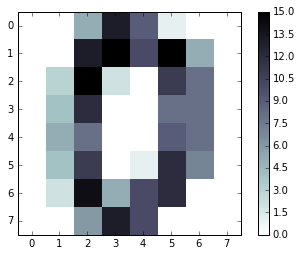

In [21]:
digit_num = 0

print(digits.data[digit_num])  # show the flattened array
grid_data = np.reshape(digits.data[digit_num], (8,8))  # reshape from 1d to 2d pixel array
plt.imshow(grid_data, interpolation = "nearest", cmap = "bone_r")
plt.colorbar()

### Principal Component Analysis

Probably the most famous (not to be confused with the best) method of dimensionality reduction adopted throughout the astronomical literature is [Principal Component Analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA). We will skip the detailed mathematics, but in short, PCA aims to reduce the dimensionality by transforming the data set to a set of linearly uncorrelated variables called principle components. The transformation is accomplished following a singular value decomposition (SVD) of the data matrix, $X$, and in many instances most of the variance of the data is retained with only a few principle components. Advantages of PCA include that it is deterministic, and in many cases, fast. One of the main disadvantages is that PCA imposes linearity and orthogonality on the projected components, which may not be adequate to describe the underlying manifold of the data (as an aside - PCA was developed over a century ago, statisticians have crafted many alternatives in the intervening time).

I have determined that the two most important pixels for differentiating digits as (0-indexed) pixels 52 and 36.  (Note - we will discuss further how I determined this tomorrow.) 

**Problem 2a** Establish a baseline for the performance of our various dimensionality reduction techniques by plotting (0-indexed) pixel 52 against pixel 36 for the digits data set. Color the points by the digit they represent. 

*Hint - this is one application where the choice of color map **really** matters. I recommend `nipy_spectral`, and this is the rare case where `jet` is a good choice.*

[ 10.  16.  16.   5.  15.  12.  11.   1.   3.   9.]


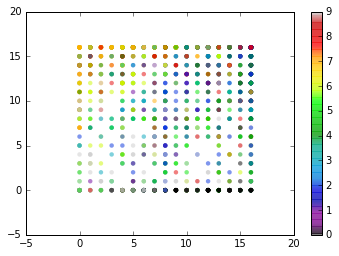

In [37]:
data52=digits.data[:,52]
data36=digits.data[:,36]
print(data52[0:10])
plt.scatter(data52,data36,alpha=.5,c=digits.target,cmap="nipy_spectral",edgecolors='none') # complete
plt.colorbar()

From this plot we see that just these two pixels do a decent job of clustering the data: the zeros are in the lower-right corner and the 7s are in the upper-right. However, there is a lot of confusion among the other digits, meaning these two pixels only capture a small fraction of the variance in the data. 

In an attempt to capture even more of the variance, we will now project the data using PCA. Again, brushing over the mathematical details, the PCA model projects the data with the following form:

$$x_i = \mu + \sum_{j = 1}^n a_{ij} v_j$$

where $x_i$ represents an individual digit image, $\mu$ represents the mean digit image, while the sum is over the eigenvectors (principal components) of the model $v_j$. The standard procedure is to list the most important eigenvectors with low $j$. In many cases, it is possible to capture most of the variance in the data using only the first few eigenvectors. 

We will project the data using the [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA) function within the [`sklearn.decomposition`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition) module. PCA models are fit in the following fashion:

    from sklearn.decomposition import PCA
    pca = PCA(n_components = None)
    pca.fit(X)
    
where `n_components` is the number of PCA components to retain (the default is the minimum between the number of samples and number of features), and `X` is the feature array.

**Problem 2b** Fit for the digits data set for the 2 leading PCA components. 

*Note - this isn't essential for this problem, but SVD on large matricies is computationally expensive $\mathcal{O}[N^3]$. For very large data sets [`RandomizedPCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.RandomizedPCA.html) can significantly improve computation times, at the cost of some accuracy.*

In [39]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2) # complete
pca.fit(digits.data)

PCA(copy=True, n_components=2, whiten=False)


Now that we have fit the PCA model, we can transform the data using the `.transform()` method, which requires a feature array as input. 

**Problem 2c** Transform the digits data set to the 2 leading PCA components, and make a scatter plot of the data in this projection. Color the points by their respective digits. How does this separation of the data compare to the use of just pixels 52 and 36?

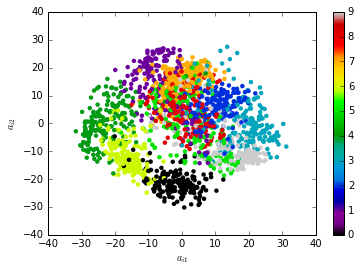

In [41]:
v_j = pca.transform(digits.data) # complete

plt.scatter(v_j[:,0],v_j[:,1],c=digits.target,cmap='nipy_spectral',edgecolors='none') # complete
plt.xlabel(r'$a_{i1}$') # complete
plt.ylabel(r'$a_{i2}$') # complete
plt.colorbar()

Here, we see that the PCA projection clusters (and visualizes) the data in a much more meaningful way.

The actual SVD eignvectors can be accessed via the `.components_` attribute, while the variance explained by each component is stored in the `.explained_variance_ratio_`.

**Problem 2d** Determine the variance explained by each of the components, as well as the total variance explained by the two components.

In [56]:
print("The first component explains {:.3f} of the variance in the data.".format(pca.explained_variance_ratio_[0])) # complete
print("The second component explains {:.3f} of the variance in the data.".format(pca.explained_variance_ratio_[1])) # complete
print("The top 2 components explain {:.3f} of the variance in the data.".format(sum(pca.explained_variance_ratio_))) # complete

The first component explains 0.149 of the variance in the data.
The second component explains 0.136 of the variance in the data.
The top 2 components explain 0.285 of the variance in the data.


**Problem 2e** How many components are needed to explain 90% of the variance in the data.

In [ ]:
for num_feats in np.arange(1,65, dtype = int):
    # complete
print("{:d} features are needed to explain 90% of the variance".format( # complete

We started with 64 features to describe the digits dataset, and now we are able to project those features into a 21-D space that captures 90% of the original variance. Doing so has allowed us to readily separate the different characters via a 2-D projection, which makes it easy to see the difference between the different numbers. 

Dimensionality reduction is useful beyond the visualization of high-dimensional data sets. It is often used as a preprocessing step before passing data to machine-learning models (imagine Google with $10^6$ features - if this can be reduced to $\sim{10}\mathrm{s}$ it will greatly improve the run time of the algorithms. PCA in particular removes correlation between the features, which is particularly useful for some algorithms, like Support Vector Machines. Finally, for a method like PCA, the eigenvectors can provide insight into the meaning of the principal components. Once again, our very own Jake VanderPlas has put together a nice tutorial on [extracting and visualing the eigenvectors of SDSS galaxy spectra](http://www.astroml.org/sklearn_tutorial/dimensionality_reduction.html). A brief note of caution - astronomers will often try to derive physical insight from PCA eigenspectra or eigentimeseries, but this is not advisable as there is no physical reason for the data to be linearly and orthogonally separable.

###Manifold Learning

*Why the advised caution against PCA?* As already noted, newer, more flexible methods have been developed. Furthermore, it is possible that the data of interest have interesting non-linear structure, which is not easily identified via PCA-like projections. Thus, an entire field, known as [Manifold Learning](http://scikit-learn.org/stable/modules/manifold.html), has been developed, with several algorithms available via the [`sklearn.manifold`](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.manifold) module. 

*Aside* I will note that an advantage of PCA is its deterministic nature, leading to stable repeatability. The results from most non-linear manifold-learning methods change from run to run.

Rather than providing detailed insight into the algorithms themselves, we will simply provide a few examples so as to compare their performance to PCA. As is often the case: the best algorithm is almost always problem dependent.

First we will begin with the [Isomap](https://en.wikipedia.org/wiki/Isomap) algorithm, which aims to measure the intrinsic geometry of a data manifold by identifying each point's neighbors on the manifold. The algorithm can be accessed from the `sklearn.manifold` module as the [`Isomap`](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html#sklearn.manifold.Isomap) function. It takes a feature array as the argument, with an optional `n_components` for the projection (like the `PCA` function). The data can then be transformed to the ISOMAP projection using the `.tranform()` method. 

    from sklearn.manifold import Isomap
    iso = Isomap()
    iso.fit(X)
    X_new = iso.transform(X)

**Problem 2f** Fit a 2 component ISOMAP model to the digits data set, and make a scatter plot showing the data in this 2D projection. Color the points based on their digit labels. How does this projection compare to PCA?

In [ ]:
from sklearn.manifold import Isomap

iso = Isomap( # complete
# complete
# complete

plt.scatter( # complete
plt.colorbar()

Finally, we conclude the dimensionality reduction with the [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) algorithm. In brief, `t-SNE` embeds high-dimensional data into 2 or 3 dimensions in such a way that preserves nearby neighbors and distant separations. Or, as one statistician once explained to me, "t-SNE is magic." [That definition is good for me, but - if you plan to use this for actual science it is worth having a better definition/explanation than "magic."]

The [`TSNE`](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) algorithm is available from the `sklearn.manifold`. Unlike `PCA` and `Isomap` there is no `transform()` method for the `TSNE` algorithm, instead the data are fit and transformed in a single step, as follows:

    from sklearn.manifold import TSNE
    tsne = TSNE()
    X_new = tsne.fit_transform(X)

**Problem 2g** Fit a 2 component t-SNE model to the digits data set, and make a scatter plot showing the data in this 2D projection. Color the points based on their digit labels. How does this projection compare to PCA and Isomap?

*Note - this algorithm is computationally intensive and this will take some time to run on your laptop.*

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE( # complete
# complete

plt.scatter( # complete
plt.colorbar()

Holy freakin' smokes. That is magic. (it's possible we just solved science)

##Problem 3) Data Exploration

Finally - the most open ended topic of the day: data exploration. In brief, data exploration encompases a large suite of tools (including those discussed above) to examine data that live in large dimensional spaces. There is no single best method or optimal direction for data exploration. Instead, today we will introduce some of the tools available via python. 

As an example we will start with a basic line plot - and examine available tools outside the standard matplotlib commands.

In [ ]:
x = np.arange(0, 6*np.pi, 0.1)
y = np.cos(x)

plt.plot(x,y, lw = 2)
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(0, 6*np.pi)

### Seaborn

[`Seaborn`](https://stanford.edu/~mwaskom/software/seaborn/index.html) is a plotting package that readily enables a lot of features that are useful for exploration. In fact, a lot of the functionality that we developed above can readily be handled with seaborne. It is a python package that has been developed expressly for data visualization. We will now explore a bit of the power of this package. 

*Aside - aesthetics vary greatly from person to person. The mere act of importing `seaborn` drastically changes the appearance of all plots made thereafter. Some really like these changes, others do not. I've heard it said that `seaborn` is no good as it forces an `import MakeUgly` under the hood. The choice is up to you.*

To begin, we will make the same plot that we created in matplotlib. 

In [ ]:
import seaborn as sns

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x,y, lw = 2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0, 6*np.pi)

We can see that the plot has significantly changed styles. 

`seaborn` has 5 style presets: `darkgrid`, `whitegrid`, `dark`, `white`, and `ticks`. You can change the preset using the following: 

    sns.set_style("whitegrid")
 
which will change the output for all subsequent plots. Note - if you want to change the style for only a single plot, that can be accomplished with the following: 

    with sns.axes_style("dark"):

with all ploting commands inside the `with` statement. 

**Problem 3a** Re-plot the sine curve using each `seaborn` preset to see which you like best - then adopt this for the remainder of the notebook. 

In [ ]:
sns.set_style("ticks")

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(x,y, lw = 2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0, 6*np.pi)

The folks behind `seaborn` have thought a lot about color palettes, which is a good thing. Remember - the choice of color for plots is one of the most essential aspects of visualization. A poor choice of colors can easily mask interesting patterns or suggest structure that is not real. To learn more about what is available, see the [`seaborn` color tutorial](http://stanford.edu/~mwaskom/software/seaborn/tutorial/color_palettes.html). 

Here we load the default:

In [ ]:
# default color palette

current_palette = sns.color_palette()
sns.palplot(current_palette)

which we will now change to `colorblind`, which is clearer to those that are colorblind.

In [ ]:
# set palette to colorblind
sns.set_palette("colorblind")

current_palette = sns.color_palette()
sns.palplot(current_palette)

Now that we have covered the basics of `seaborn` (and the above examples truly only scratch the surface of what is possible), we will explore the power of `seaborn` for higher dimension data sets. We will load the famous Iris data set, which measures 4 different features of 3 different types of Iris flowers. There are 150 different flowers in the data set. (We will cover the Iris data in far more detail tomorrow.)

*Note - for those familiar with `pandas` `seaborn` is designed to integrate easily and directly with `pandas DataFrame` objects. In the example below the Iris data are loaded into a `DataFrame`. `iPython` notebooks also display the `DataFrame` data in a nice readable format.* 

In [ ]:
iris = sns.load_dataset("iris")
iris

Now that we have a sense of the data structure, it is useful to examine the distribution of features. Above, we went to great pains to produce histograms, KDEs, and rug plots. `seaborn` handles all of that effortlessly with the `distplot` function.

**Problem 3b** Plot the distribution of petal lengths for the Iris data set. 

In [ ]:
# note - hist, kde, and rug all explicitly set to True, set to False to turn them off 
with sns.axes_style("dark"):
    sns.distplot(iris['petal_length'], bins=20, hist=True, kde=True, rug=True)

Of course, this data set lives in a 4D space, so plotting more than univariate distributions is important (and as we will see tomorrow this is particularly useful for visualizing classification results). Fortunately, `seaborn` makes it very easy to produce handy summary plots. 

At this point, we are familiar with basic scatter plots in matplotlib.

**Problem 3c** Make a matplotlib scatter plot showing the Iris petal length against the Iris petal width.

In [ ]:
plt.scatter( # complete
plt.xlabel( # complete
plt.ylabel( # complete

Of course, when there are many many data points, scatter plots become difficult to interpret. As in the example below:

In [ ]:
# execute this cell

with sns.axes_style("darkgrid"):
    xexample = np.random.normal(loc = 0.2, scale = 1.1, size = 10000)
    yexample = np.random.normal(loc = -0.1, scale = 0.9, size = 10000)

    plt.scatter(xexample, yexample)

Here, we see that there are many points, clustered about the origin, but we have no sense of the underlying density of the distribution. 2D histograms, such as `plt.hist2d()`, can alleviate this problem. I prefer to use `hexbin` which is a little easier on the eyes (though note - these histograms are just as subject to the same issues discussed above). 

In [ ]:
# hexbin w/ bins = "log" returns the log of counts/bin
# mincnt = 1 displays only hexpix with at least 1 source present
with sns.axes_style("darkgrid"):
    plt.hexbin(xexample, yexample, bins = "log", cmap = "viridis", mincnt = 1)
    plt.colorbar()

While the above plot provides a significant improvement over the scatter plot by providing a better sense of the density near the center of the distribution, the binedge effects are clearly present. An even better solution, like before, is a density estimate, which is easily built into `seaborn` via the `kdeplot` function.

In [ ]:
with sns.axes_style("darkgrid"):
    sns.kdeplot(xexample, yexample,shade=False)

This plot is much more appealing (and informative) than the previous two. For the first time we can clearly see that the distribution is not actually centered on the origin. Now we will move back to the Iris data set. 

Suppose we want to see univariate distributions in addition to the scatter plot? This is certainly possible with `matplotlib` and you can find examples on the web, however, with `seaborn` this is really easy.

In [ ]:
sns.jointplot(x=iris['petal_length'], y=iris['petal_width'])

But! Histograms and scatter plots can be problematic as we have discussed many times before. 

**Problem 3d** Re-create the plot above but set `kind='kde'` to produce density estimates of the distributions.

That is much nicer than what was presented above. However - we still have a problem in that our data live in 4D, but we are (mostly) limited to 2D projections of that data. One way around this is via the `seaborn` version of a `pairplot`, which plots the distribution of every variable in the data set again each other. (Here is where the integration with `pandas DataFrame`s becomes so powerful.)

In [ ]:
sns.pairplot(iris[["sepal_length", "sepal_width", "petal_length", "petal_width"]])

For data sets where we have classification labels, we can even color the various points using the `hue` option, and produce KDEs along the diagonal with `diag_type = 'kde'`.

In [ ]:
sns.pairplot(iris, vars = ["sepal_length", "sepal_width", "petal_length", "petal_width"],
             hue = "species", diag_kind = 'kde')

Even better - there is an option to create a `PairGrid` which allows fine tuned control of the data as displayed above, below, and along the diagonal. In this way it becomes possible to avoid having symmetric redundancy, which is not all that informative. In the example below, we will show scatter plots and contour plots simultaneously. 

In [ ]:
g = sns.PairGrid(iris, vars = ["sepal_length", "sepal_width", "petal_length", "petal_width"],
                 hue = "species", diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(plt.scatter, edgecolor='white')
g.map_diag(sns.kdeplot, lw=3)

Note - one disadvantage to the plot above is that the contours do not share the same color scheme as the KDE estimates and the scatter plot. I have not been able to figure out how to change this in a satisfactory way. (One potential solution is detailed [here](http://stackoverflow.com/questions/32889590/seaborn-pairgrid-using-kdeplot-with-2-hues), however, it is worth noting that this solution restricts your color choices to a maximum of ~5 unless you are a colormaps wizard, and I am not.)

Following that whirlwind tour through `seaborn`, which has lots of additional functionality that we have not covered today, we now conclude with an open ended question. 

**Problem 3e** Using the various tools that you have learned about in the past hour, visualize the data from the database provided by Tamas in some interesting fashion. We will re-convene as a group shortly and share our different findings.  

*Hint - there is no single correct answer here.*

In [ ]:
# for those curious - this is how I determined the most important features for the digits data set

from sklearn.ensemble import RandomForestRegressor

RFreg = RandomForestRegressor(n_estimators = 100)
RFreg.fit(digits.data, digits.target)
np.argsort(RFreg.feature_importances_)[::-1]